notMINST Data Setup
===================

This notebook sets up the the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

This notebook is derived from the [Udacity Tensorflow Course Assignment 1](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb)

In [1]:
%matplotlib inline
from __future__ import print_function

import gzip
import os
import sys
import tarfile
import urllib

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Image
from scipy import ndimage
from six.moves import cPickle as pickle

import outputer

Setup auto-flush and tee


Download the dataset of characters 'A' to 'J' rendered in various fonts as 28x28 images.

There is training set of about 500k images and a test set of about 19000 images.

In [2]:
url = "http://yaroslavvb.com/upload/notMNIST/"
data_path = "notMNIST"

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print("Found", filename, "with correct size.")
    else:
        raise Exception("Error downloading" + filename)
    return filename

train_filename = maybe_download(os.path.join(data_path, "notMNIST_large.tar.gz"), 247336696)
test_filename = maybe_download(os.path.join(data_path, "notMNIST_small.tar.gz"), 8458043)

Found notMNIST/notMNIST_large.tar.gz with correct size.
Found notMNIST/notMNIST_small.tar.gz with correct size.


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
def extract(filename, root, class_count):
    dir_name = os.path.splitext(os.path.splitext(os.path.basename(filename))[0])[0]  # remove .tar.gz
    path = os.path.join(root, dir_name)
    print("Extracting", filename, "to", path)
    tar = tarfile.open(filename)
    tar.extractall(path=root)
    tar.close()
    data_folders = [os.path.join(path, d) for d in sorted(os.listdir(path))]
    if len(data_folders) != class_count:
        raise Exception("Expected %d folders, one per class. Found %d instead." % (class_count, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = []
test_folders = []

for name in os.listdir(data_path):
    path = os.path.join(data_path, name)
    target = None
    print("Checking", path)
    if path.endswith("_small"):
        target = test_folders
    elif path.endswith("_large"):
        target = train_folders
    if target is not None:
        target.extend([os.path.join(path, name) for name in os.listdir(path)])
        print("Found", target)

expected_classes = 10

if len(train_folders) < expected_classes:
    train_folders = extract(train_filename, data_path, expected_classes)

if len(test_folders) < expected_classes:
    test_folders = extract(test_filename, data_path, expected_classes)

Checking notMNIST/notMNIST_small
Found ['notMNIST/notMNIST_small/A', 'notMNIST/notMNIST_small/E', 'notMNIST/notMNIST_small/B', 'notMNIST/notMNIST_small/J', 'notMNIST/notMNIST_small/H', 'notMNIST/notMNIST_small/F', 'notMNIST/notMNIST_small/G', 'notMNIST/notMNIST_small/I', 'notMNIST/notMNIST_small/C', 'notMNIST/notMNIST_small/D']
Checking notMNIST/notMNIST_small.tar.gz
Checking notMNIST/full.pickle
Checking notMNIST/notMNIST_large.tar.gz
Checking notMNIST/notMNIST_large
Found ['notMNIST/notMNIST_large/A', 'notMNIST/notMNIST_large/E', 'notMNIST/notMNIST_large/B', 'notMNIST/notMNIST_large/J', 'notMNIST/notMNIST_large/H', 'notMNIST/notMNIST_large/F', 'notMNIST/notMNIST_large/G', 'notMNIST/notMNIST_large/I', 'notMNIST/notMNIST_large/C', 'notMNIST/notMNIST_large/D']


# Inspect Data

Verify that the images contain rendered glyphs.

In [4]:
Image(filename="notMNIST/notMNIST_small/A/MDEtMDEtMDAudHRm.png")

In [5]:
Image(filename="notMNIST/notMNIST_large/A/a2F6b28udHRm.png")

In [6]:
Image(filename="notMNIST/notMNIST_large/C/ZXVyb2Z1cmVuY2UgaXRhbGljLnR0Zg==.png")

In [7]:
# This I is all white
Image(filename="notMNIST/notMNIST_small/I/SVRDIEZyYW5rbGluIEdvdGhpYyBEZW1pLnBmYg==.png")

Convert the data into an array of normalized grayscale floating point images, and an array of classification labels.

Unreadable images are skipped.

In [10]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

# Captured list of bad files from previous run (to avoid noisy output)
skip_list = [
    "notMNIST/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png",
    "notMNIST/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png",
    "notMNIST/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png",
    "notMNIST/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png",
    "notMNIST/notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png",
    "notMNIST/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png",
    "notMNIST/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png"
]

def load(data_folders, set_id, min_count, max_count):
    # Create arrays large enough for maximum expected data.
    dataset = np.ndarray(shape=(max_count, image_size, image_size), dtype=np.float32)
    labels = np.ndarray(shape=(max_count), dtype=np.int32)
    label_index = 0
    image_index = 0
    
    solid_blacks = []
    solid_whites = []
    
    for folder in sorted(data_folders):
        print(folder)
        for image in os.listdir(folder):
            if image_index >= max_count:
                raise Exception("More than %d images!" % (max_count,))
            image_file = os.path.join(folder, image)
            if image_file in skip_list:
                continue
            try:
                raw_data = ndimage.imread(image_file)
                
                # Keep track of images a that are solid white or solid black.
                if np.all(raw_data == 0):
                    solid_blacks.append(image_file)
                if np.all(raw_data == int(pixel_depth)):
                    solid_whites.append(image_file)
                
                # Convert to float and normalize.
                image_data = (raw_data.astype(float) - pixel_depth / 2) / pixel_depth

                if image_data.shape != (image_size, image_size):
                    raise Exception("Unexpected image shape: %s" % str(image_data.shape))

                # Capture the image data and label.
                dataset[image_index, :, :] = image_data
                labels[image_index] = label_index
                image_index += 1
            except IOError as e:
                skip_list.append(image_file)
                print("Could not read:", image_file, ':', e, "skipping.")
        label_index += 1
    image_count = image_index
    # Trim down to just the used portion of the arrays.
    dataset = dataset[0:image_count, :, :]
    labels = labels[0:image_count]
    if image_count < min_count:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    print("Input data shape:", dataset.shape)
    print("Mean of all normalized pixels:", np.mean(dataset))
    print("Standard deviation of normalized pixels:", np.std(dataset))
    print('Labels shape:', labels.shape)
    print("Found", len(solid_whites), "solid white images, and", len(solid_blacks), "solid black images.")
    return dataset, labels

In [11]:
train_dataset, train_labels = load(train_folders, "train", 450000, 550000)
test_dataset, test_labels = load(test_folders, 'test', 18000, 20000)

skip_list

notMNIST/notMNIST_large/A
notMNIST/notMNIST_large/B
notMNIST/notMNIST_large/C
notMNIST/notMNIST_large/D
notMNIST/notMNIST_large/E
notMNIST/notMNIST_large/F
notMNIST/notMNIST_large/G
notMNIST/notMNIST_large/H
notMNIST/notMNIST_large/I
notMNIST/notMNIST_large/J
Input data shape: (529114, 28, 28)
Mean of all normalized pixels: -0.0816592
Standard deviation of normalized pixels: 0.454232
Labels shape: (529114,)
Found 5552 solid white images, and 0 solid black images.
notMNIST/notMNIST_small/A
notMNIST/notMNIST_small/B
notMNIST/notMNIST_small/C
notMNIST/notMNIST_small/D
notMNIST/notMNIST_small/E
notMNIST/notMNIST_small/F
notMNIST/notMNIST_small/G
notMNIST/notMNIST_small/H
notMNIST/notMNIST_small/I
notMNIST/notMNIST_small/J
Input data shape: (18724, 28, 28)
Mean of all normalized pixels: -0.0746363
Standard deviation of normalized pixels: 0.458622
Labels shape: (18724,)
Found 254 solid white images, and 0 solid black images.


['notMNIST/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png',
 'notMNIST/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png',
 'notMNIST/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png',
 'notMNIST/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png',
 'notMNIST/notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png',
 'notMNIST/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png',
 'notMNIST/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png']

# Verify Proccessed Data

0

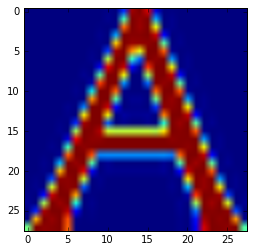

In [12]:
exemplar = plt.imshow(train_dataset[0])
train_labels[0]

0

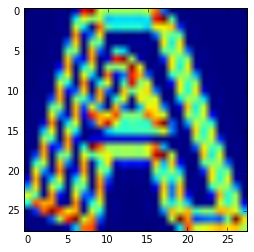

In [13]:
exemplar = plt.imshow(train_dataset[373])
train_labels[373]

9

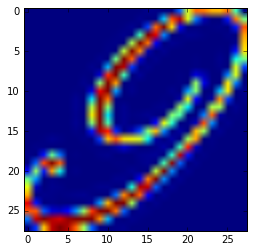

In [14]:
exemplar = plt.imshow(test_dataset[18169])
test_labels[18169]

9

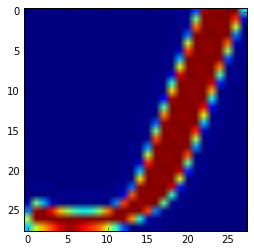

In [15]:
exemplar = plt.imshow(train_dataset[-9])
train_labels[-9]

# Compress and Store Data

In [16]:
pickle_file = 'notMNIST/full.pickle'

try:
    f = gzip.open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 266785730
